<a href="https://colab.research.google.com/github/prant1719/BADS7105-CRM/blob/main/HW8_Campaign%20Response/HW8_Campaign_Response.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing libraries and datasets**

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [4]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [5]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [6]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


# EDA


In [7]:
df_transactions.describe()

,tran_amount
count,125000.000000
mean,64.991912
std,22.860006
min,10.000000
25%,47.000000
50%,65.000000
75%,83.000000
max,105.000000


In [8]:
df_response.describe()

,response
count,6884.000000
mean,0.093986
std,0.291831
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


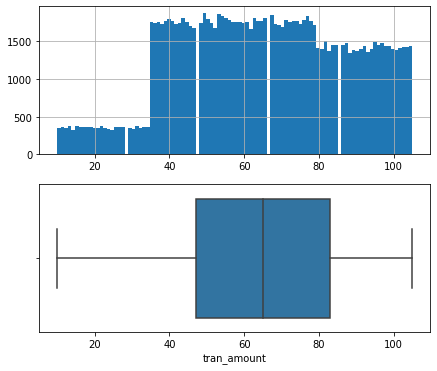

In [9]:
fig, axes = plt.subplots(2,1, figsize=(7,6))
df_transactions['tran_amount'].hist(bins=100, ax=axes[0])
sns.boxplot(data=df_transactions, x='tran_amount', ax=axes[1]);

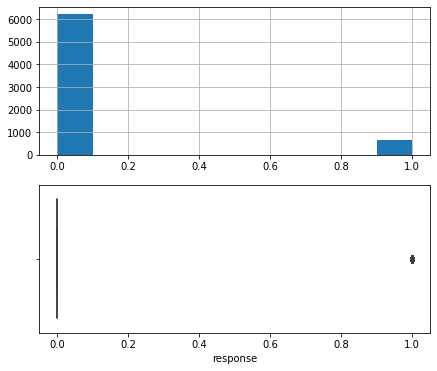

In [10]:
fig, axes = plt.subplots(2,1, figsize=(7,6))
df_response['response'].hist(bins=10, ax=axes[0])
sns.boxplot(data=df_response, x='response', ax=axes[1]);

## **Data Preparation**

In [11]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions = df_transactions[df_transactions['trans_date']>dt.datetime(2012,1,1)]
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
4,CS1850,2013-11-20,78,482.0
5,CS5539,2014-03-26,81,356.0


In [12]:
## create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                  
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                      
                       'trans_date' : 'AOU'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']

In [13]:
df_clv = df_clv.reset_index()
df_clv.head()

,customer_id,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,62.0,12,800,1011,66.666667
1,CS1113,36.0,17,1246,1046,73.294118
2,CS1114,33.0,14,1006,1005,71.857143
3,CS1115,12.0,19,1398,1154,73.578947
4,CS1116,204.0,9,622,923,69.111111


## **Calculating response rate**

In [14]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


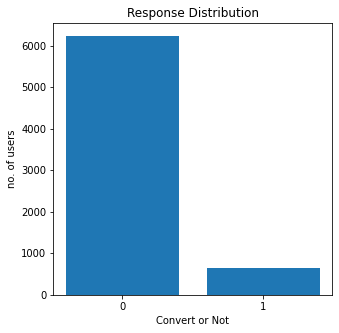

In [15]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [16]:
## merging two data sets - CLV

df_modeling_clv = pd.merge(df_response,df_clv)
df_modeling_clv.head()

,customer_id,response,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,0,62.0,12,800,1011,66.666667
1,CS1113,0,36.0,17,1246,1046,73.294118
2,CS1114,1,33.0,14,1006,1005,71.857143
3,CS1115,1,12.0,19,1398,1154,73.578947
4,CS1116,1,204.0,9,622,923,69.111111


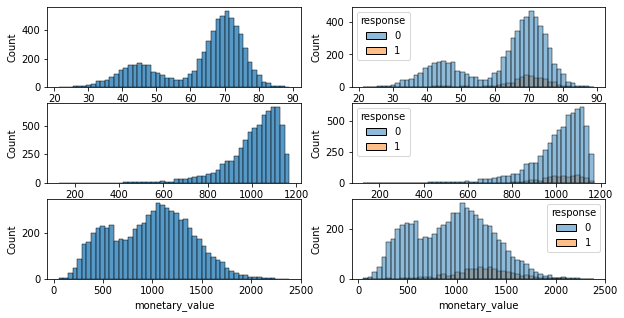

In [17]:
fig, axes = plt.subplots(3,2, figsize=(10,5))
axes = axes.ravel()
sns.histplot(data=df_modeling_clv, x='ticket_size',bins=50, ax=axes[0])
sns.histplot(data=df_modeling_clv, x='ticket_size',bins=50, hue='response', ax=axes[1])
sns.histplot(data=df_modeling_clv, x='AOU',bins=50, ax=axes[2])
sns.histplot(data=df_modeling_clv, x='AOU',bins=50, hue='response', ax=axes[3])
sns.histplot(data=df_modeling_clv, x='monetary_value',bins=50, ax=axes[4])
sns.histplot(data=df_modeling_clv, x='monetary_value',bins=50, hue='response', ax=axes[5])
plt.show();

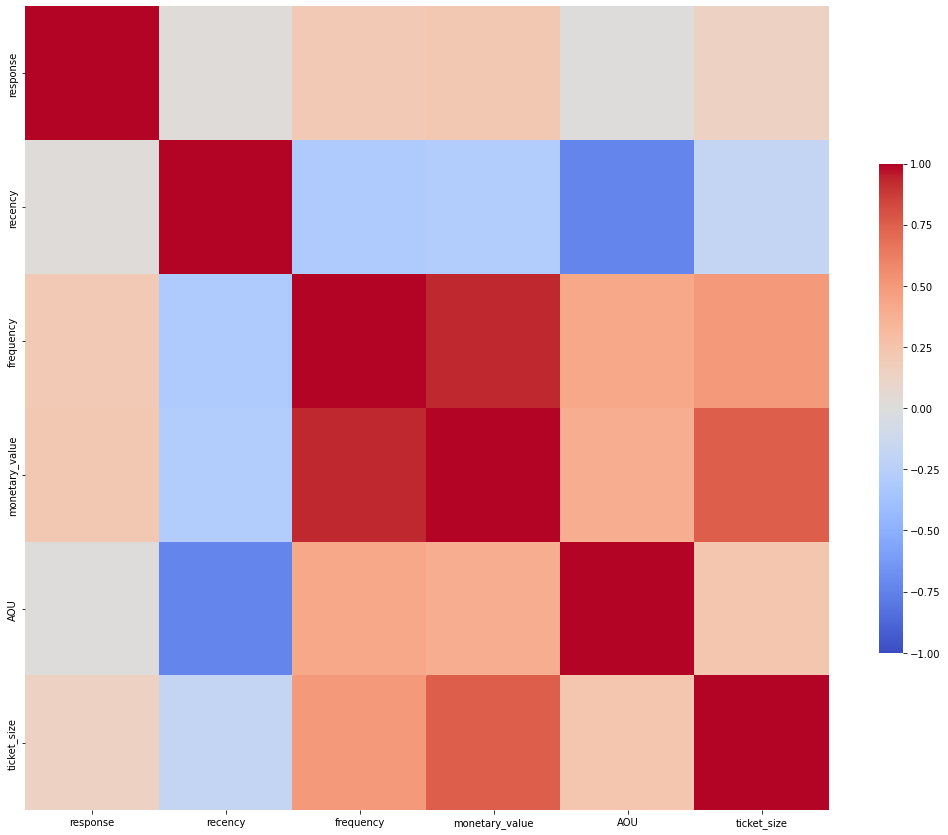

In [18]:
plt.figure(figsize=(18,18))
sns.heatmap(df_modeling_clv.corr(), cmap='coolwarm', vmin=-1, vmax=1, annot=False, fmt='.1f', square=True, cbar_kws = {'shrink':.5});

## **Creating train and test dataset**

In [19]:
## spliting dataframe into X and y

X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

In [20]:
X_clv.head()

,recency,frequency,monetary_value,AOU,ticket_size
0,62.0,12,800,1011,66.666667
1,36.0,17,1246,1046,73.294118
2,33.0,14,1006,1005,71.857143
3,12.0,19,1398,1154,73.578947
4,204.0,9,622,923,69.111111


In [21]:
y_clv.head()

0    0
1    0
2    1
3    1
4    1
Name: response, dtype: int64

In [22]:
## creating train and test dataset

X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.25, random_state=0)

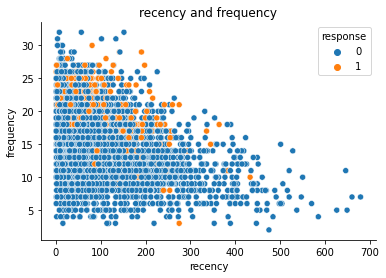

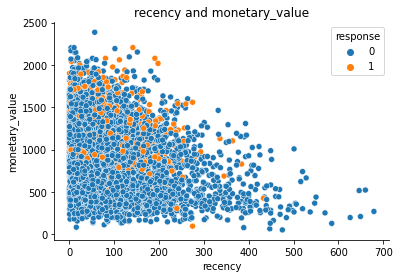

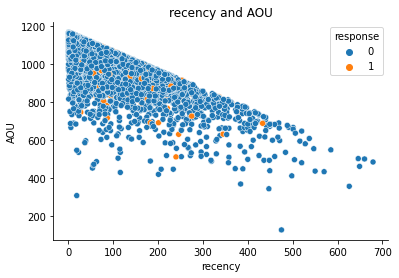

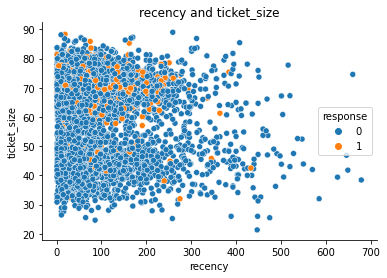

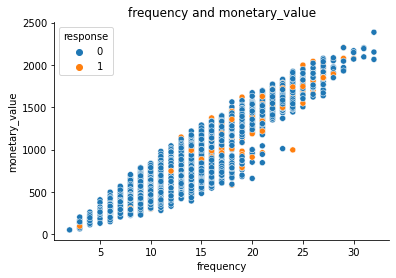

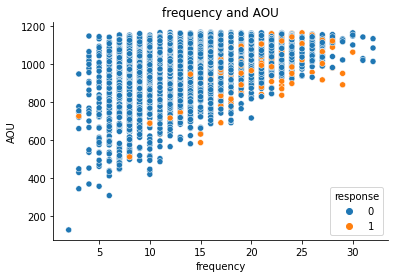

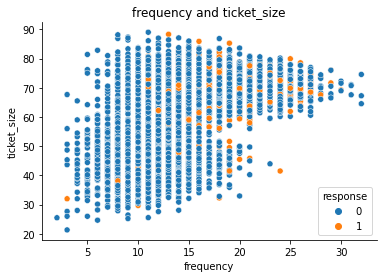

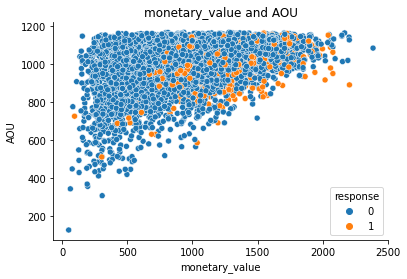

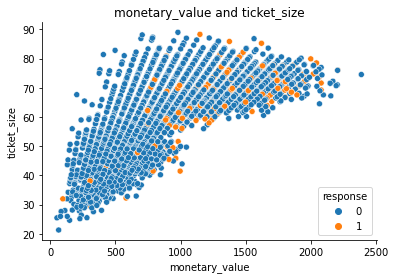

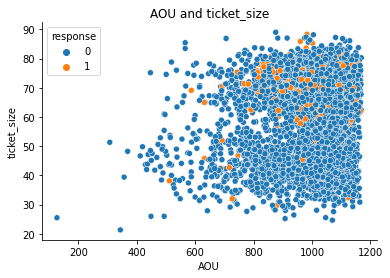

In [23]:
for i, col_i in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
  for j, col_j in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

## **Fixing imbalanced with SMOTE**

In [24]:
sm = SMOTE(random_state=0)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_sample(X_train_clv, y_train_clv)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [25]:
from imblearn.combine import SMOTETomek

smtom = SMOTETomek(random_state=120)
x_train_smtom ,y_train_smtom = smtom.fit_sample(X_train_clv,y_train_clv)

print(y_train_smtom)

[0 0 0 ... 1 1 1]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [26]:
from imblearn.combine import SMOTEENN

smenn = SMOTEENN()
x_train_smenn ,y_train_smenn = smenn.fit_sample(X_train_clv,y_train_clv)

print(y_train_smenn)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0 0 0 ... 1 1 1]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## **Logistic Regression**

logistic regression model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.68      0.65      0.67      4691
           1       0.67      0.70      0.68      4691

    accuracy                           0.68      9382
   macro avg       0.68      0.68      0.67      9382
weighted avg       0.68      0.68      0.67      9382

AUC Score 0.6751225751438926
test set
              precision    recall  f1-score   support

           0       0.96      0.65      0.78      1546
           1       0.19      0.74      0.31       175

    accuracy                           0.66      1721
   macro avg       0.57      0.69      0.54      1721
weighted avg       0.88      0.66      0.73      1721

AUC Score 0.6945740158935503
ROC Curve
ROC Curve: 0.7488042875623728


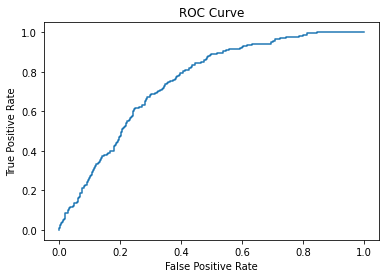

In [54]:
print('logistic regression model - SMOTE CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_clv = logreg.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = logreg_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 
print('AUC Score',roc_auc_score(expected_y,predicted_y))  

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 
print('AUC Score',roc_auc_score(expected_y,predicted_y)) 
#create ROC curve
from sklearn import metrics
print('ROC Curve')
#define metrics
y_pred_proba = logreg_model_SMOTE_clv.predict_proba(X_test_clv)[::,1]
fpr, tpr, thresholds = roc_curve(y_test_clv, y_pred_proba)

roc_auc = roc_auc_score(y_test_clv, y_pred_proba)
print("ROC Curve:", roc_auc)

#create AUC curve
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

logistic regression model - SMOTETomek CLV
training set
              precision    recall  f1-score   support

           0       0.70      0.65      0.67      4517
           1       0.67      0.73      0.70      4517

    accuracy                           0.69      9034
   macro avg       0.69      0.69      0.69      9034
weighted avg       0.69      0.69      0.69      9034

AUC Score 0.6867389860526898
test set
              precision    recall  f1-score   support

           0       0.96      0.64      0.77      1546
           1       0.19      0.75      0.30       175

    accuracy                           0.65      1721
   macro avg       0.57      0.69      0.54      1721
weighted avg       0.88      0.65      0.72      1721

AUC Score 0.6947902420994271
ROC Curve
ROC Curve: 0.7501053409720939


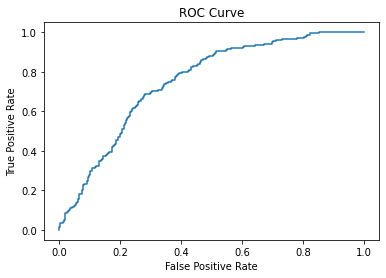

In [53]:
print('logistic regression model - SMOTETomek CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTET_clv = logreg.fit(x_train_smtom, y_train_smtom)
predictions = logreg_model_SMOTET_clv.predict(x_train_smtom)
predicted_y.extend(predictions)
expected_y.extend(y_train_smtom)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 
print('AUC Score',roc_auc_score(expected_y,predicted_y))  

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTET_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 
print('AUC Score',roc_auc_score(expected_y,predicted_y)) 


#create ROC curve
from sklearn import metrics
print('ROC Curve')
#define metrics
y_pred_proba = logreg_model_SMOTET_clv.predict_proba(X_test_clv)[::,1]
fpr, tpr, thresholds = roc_curve(y_test_clv, y_pred_proba)

roc_auc = roc_auc_score(y_test_clv, y_pred_proba)
print("ROC Curve:", roc_auc)

#create AUC curve
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

logistic regression model - SMOTEENN CLV
training set
              precision    recall  f1-score   support

           0       0.71      0.74      0.72      2924
           1       0.80      0.77      0.78      3847

    accuracy                           0.76      6771
   macro avg       0.75      0.76      0.75      6771
weighted avg       0.76      0.76      0.76      6771

AUC Score 0.7553310946010483
test set
              precision    recall  f1-score   support

           0       0.95      0.60      0.74      1546
           1       0.17      0.74      0.28       175

    accuracy                           0.62      1721
   macro avg       0.56      0.67      0.51      1721
weighted avg       0.87      0.62      0.69      1721

AUC Score 0.6728515985954537
AUC Curve
AUC of ROC Curve: 0.7417150249491775


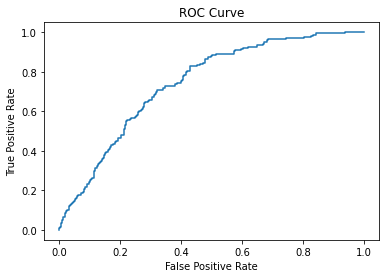

In [51]:
print('logistic regression model - SMOTEENN CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTEENN_clv = logreg.fit(x_train_smenn, y_train_smenn)
predictions = logreg_model_SMOTEENN_clv.predict(x_train_smenn)
predicted_y.extend(predictions)
expected_y.extend(y_train_smenn)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 
print('AUC Score',roc_auc_score(expected_y,predicted_y))  

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTEENN_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 
print('AUC Score',roc_auc_score(expected_y,predicted_y)) 

#create ROC curve
from sklearn import metrics
print('ROC Curve')
#define metrics
y_pred_proba = logreg_model_SMOTEENN_clv .predict_proba(X_test_clv)[::,1]
fpr, tpr, thresholds = roc_curve(y_test_clv, y_pred_proba)

roc_auc = roc_auc_score(y_test_clv, y_pred_proba)
print("AUC of ROC Curve:", roc_auc)

#create ROC curve
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

## **XGBoost**

In [61]:
print('XGBoost model - SMOTE CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.05,
 n_estimators=100,
 max_depth=2,
 gamma=0,
 scale_pos_weight = 1,
 colsample_bytree=0.8,
 nthread=4,
 seed=20)

predicted_y = []
expected_y = []

xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv, y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv.to_numpy(), y_test_clv)])
predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train)
print('AUC Score',roc_auc_score(expected_y,predicted_y)) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)
print('AUC Score',roc_auc_score(expected_y,predicted_y)) 






XGBoost model - SMOTE CLV
[0]	validation_0-auc:0.698913
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.710216
[2]	validation_0-auc:0.708915
[3]	validation_0-auc:0.713905
[4]	validation_0-auc:0.722811
[5]	validation_0-auc:0.726052
[6]	validation_0-auc:0.73761
[7]	validation_0-auc:0.737082
[8]	validation_0-auc:0.740174
[9]	validation_0-auc:0.741613
[10]	validation_0-auc:0.738534
[11]	validation_0-auc:0.741508
[12]	validation_0-auc:0.739233
[13]	validation_0-auc:0.741588
[14]	validation_0-auc:0.742863
[15]	validation_0-auc:0.743942
[16]	validation_0-auc:0.743999
[17]	validation_0-auc:0.745437
[18]	validation_0-auc:0.745607
[19]	validation_0-auc:0.745208
[20]	validation_0-auc:0.744827
[21]	validation_0-auc:0.745871
[22]	validation_0-auc:0.746539
[23]	validation_0-auc:0.749331
[24]	validation_0-auc:0.749368
[25]	validation_0-auc:0.749793
[26]	validation_0-auc:0.747516
[27]	validation_0-auc:0.748074
[28]	validation_0-auc:0.747923
[29]	validation_0-auc:0

In [31]:
print('XGBoost model - SMOTETomek CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.05,
 n_estimators=100,
 max_depth=2,
 gamma=0,
 scale_pos_weight = 1,
 colsample_bytree=0.8,
 nthread=4,
 seed=20)

predicted_y = []
expected_y = []

xgb_model_SMOTETomek_clv = xgb_model.fit(x_train_smtom, y_train_smtom, early_stopping_rounds=5, eval_set=[(X_test_clv.to_numpy(), y_test_clv)])
predictions =  xgb_model_SMOTETomek_clv.predict(x_train_smtom)
predicted_y.extend(predictions)
expected_y.extend(y_train_smtom)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train)
print('AUC Score',roc_auc_score(expected_y,predicted_y)) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTETomek_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)
print('AUC Score',roc_auc_score(expected_y,predicted_y))

XGBoost model - SMOTETomek CLV
[0]	validation_0-auc:0.686134
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.701715
[2]	validation_0-auc:0.715173
[3]	validation_0-auc:0.723079
[4]	validation_0-auc:0.729327
[5]	validation_0-auc:0.730573
[6]	validation_0-auc:0.735463
[7]	validation_0-auc:0.736729
[8]	validation_0-auc:0.735622
[9]	validation_0-auc:0.736869
[10]	validation_0-auc:0.73596
[11]	validation_0-auc:0.739974
[12]	validation_0-auc:0.739538
[13]	validation_0-auc:0.743439
[14]	validation_0-auc:0.745136
[15]	validation_0-auc:0.745043
[16]	validation_0-auc:0.744685
[17]	validation_0-auc:0.746607
[18]	validation_0-auc:0.74652
[19]	validation_0-auc:0.746675
[20]	validation_0-auc:0.747477
[21]	validation_0-auc:0.747875
[22]	validation_0-auc:0.749398
[23]	validation_0-auc:0.74986
[24]	validation_0-auc:0.750845
[25]	validation_0-auc:0.751107
[26]	validation_0-auc:0.750466
[27]	validation_0-auc:0.750484
[28]	validation_0-auc:0.75037
[29]	validation_0-auc

In [32]:
print('XGBoost model - SMOTEENN CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.05,
 n_estimators=100,
 max_depth=2,
 gamma=0,
 scale_pos_weight = 1,
 colsample_bytree=0.8,
 nthread=4,
 seed=20)

predicted_y = []
expected_y = []

xgb_model_SMOTEENN_clv = xgb_model.fit(x_train_smenn, y_train_smenn, early_stopping_rounds=5, eval_set=[(X_test_clv.to_numpy(), y_test_clv)])
predictions =  xgb_model_SMOTEENN_clv.predict(x_train_smenn)
predicted_y.extend(predictions)
expected_y.extend(y_train_smenn)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train)
print('AUC Score',roc_auc_score(expected_y,predicted_y)) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTEENN_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)
print('AUC Score',roc_auc_score(expected_y,predicted_y))

XGBoost model - SMOTEENN CLV
[0]	validation_0-auc:0.693572
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.693572
[2]	validation_0-auc:0.713173
[3]	validation_0-auc:0.725877
[4]	validation_0-auc:0.73185
[5]	validation_0-auc:0.728457
[6]	validation_0-auc:0.728631
[7]	validation_0-auc:0.730745
[8]	validation_0-auc:0.728505
[9]	validation_0-auc:0.728542
Stopping. Best iteration:
[4]	validation_0-auc:0.73185

training set
              precision    recall  f1-score   support

           0       0.78      0.69      0.73      2924
           1       0.78      0.85      0.82      3847

    accuracy                           0.78      6771
   macro avg       0.78      0.77      0.78      6771
weighted avg       0.78      0.78      0.78      6771

AUC Score 0.7728383852679634
test set
              precision    recall  f1-score   support

           0       0.96      0.53      0.68      1546
           1       0.16      0.78      0.26       175

    accurac

# SVM

In [65]:
print('SVM model - SMOTE CLV')
from sklearn import svm
clf = svm.SVC(kernel='linear')
predicted_y = []
expected_y = []
# Train the model on training data
sv_model_SMOTE_clv = clf.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions =  sv_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train)
print('AUC Score',roc_auc_score(expected_y,predicted_y)) 

predicted_y = []
expected_y = []
predictions = sv_model_SMOTE_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)
print('AUC Score',roc_auc_score(expected_y,predicted_y))




SVM model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.73      0.59      0.65      4691
           1       0.66      0.78      0.71      4691

    accuracy                           0.69      9382
   macro avg       0.69      0.69      0.68      9382
weighted avg       0.69      0.69      0.68      9382

AUC Score 0.6871669153698572
test set
              precision    recall  f1-score   support

           0       0.96      0.60      0.73      1546
           1       0.18      0.78      0.29       175

    accuracy                           0.61      1721
   macro avg       0.57      0.69      0.51      1721
weighted avg       0.88      0.61      0.69      1721

AUC Score 0.6861134725559046


In [66]:
print('SVM model - SMOTETomek CLV')
from sklearn import svm
clf = svm.SVC(kernel='linear')
predicted_y = []
expected_y = []
# Train the model on training data
sv_model_SMOTET_clv = clf.fit(x_train_smtom, y_train_smtom)
predictions =  sv_model_SMOTET_clv.predict(x_train_smtom)
predicted_y.extend(predictions)
expected_y.extend(y_train_smtom)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train)
print('AUC Score',roc_auc_score(expected_y,predicted_y)) 

predicted_y = []
expected_y = []
predictions = sv_model_SMOTET_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)
print('AUC Score',roc_auc_score(expected_y,predicted_y))

SVM model - SMOTETomek CLV
training set
              precision    recall  f1-score   support

           0       0.74      0.59      0.66      4517
           1       0.66      0.79      0.72      4517

    accuracy                           0.69      9034
   macro avg       0.70      0.69      0.69      9034
weighted avg       0.70      0.69      0.69      9034

AUC Score 0.6918308611910561
test set
              precision    recall  f1-score   support

           0       0.96      0.58      0.73      1546
           1       0.18      0.81      0.29       175

    accuracy                           0.60      1721
   macro avg       0.57      0.69      0.51      1721
weighted avg       0.88      0.60      0.68      1721

AUC Score 0.6936074662724081


In [35]:
print('SVM model - SMOTEENNomek CLV'
from sklearn import svm
clf = svm.SVC(kernel='linear')
predicted_y = []
expected_y = []
# Train the model on training data

sv_model_SMOTEENN_clv = clf.fit(x_train_smenn, y_train_smenn)
predictions =  sv_model_SMOTEENN_clv.predict(x_train_smenn)
predicted_y.extend(predictions)
expected_y.extend(y_train_smenn)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train)
print('AUC Score',roc_auc_score(expected_y,predicted_y)) 

predicted_y = []
expected_y = []
predictions = sv_model_SMOTEENN_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)
print('AUC Score',roc_auc_score(expected_y,predicted_y))



training set
              precision    recall  f1-score   support

           0       0.84      0.62      0.72      2924
           1       0.76      0.91      0.83      3847

    accuracy                           0.79      6771
   macro avg       0.80      0.77      0.77      6771
weighted avg       0.79      0.79      0.78      6771

AUC Score 0.7667945370759883
test set
              precision    recall  f1-score   support

           0       0.97      0.48      0.64      1546
           1       0.16      0.89      0.27       175

    accuracy                           0.52      1721
   macro avg       0.57      0.68      0.46      1721
weighted avg       0.89      0.52      0.60      1721

AUC Score 0.6815376085751248
